# CS421 Project: Appendix (Exploratory Data Analysis)
---

Group: Empirical Risk Minimisers  
Members:
- Lai Wan Xuan Joanne (joanne.lai.2021)
- Ryan Miguel Moralde Sia (ryansia.2022)
- Dhruv Benegal (benegalda.2022)
- Benedict Lee Zi Le (benedictlee.2022)

In this notebook, we explore statistics related to the dataset, and determine which additional features to create in order to create better prediction models.

## Exploratory Data Analysis

In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import (
    kurtosis,
    skew,
    entropy
)

# Suppress FutureWarnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)

# Set up the Seaborn style
sns.set_style("whitegrid")
%matplotlib inline

In [97]:
# Load the data
first_batch  = np.load("data/Week1/first_batch_regression_labelled.npz")
second_batch  = np.load("data/Week2/second_batch_regression_labelled.npz")
third_batch  = np.load("data/Week3/third_batch_regression_labelled.npz")
fourth_batch  = np.load("data/Week4/fourth_batch_regression_labelled.npz")

# Extract X, y, y_cat for each batch
X1, y1, y1_cat = first_batch["X"], first_batch["yy"], first_batch["yy_cat"]
X2, y2, y2_cat = second_batch["X"], second_batch["yy"], second_batch["yy_cat"]
X3, y3, y3_cat = third_batch["X"], third_batch["yy"], third_batch["yy_cat"]
X4, y4, y4_cat = fourth_batch["X"], fourth_batch["yy"], fourth_batch["yy_cat"]

# Convert to DataFrames and rename columns for each batch
X1     = pd.DataFrame(X1, columns=["user", "item", "rating"])
y1     = pd.DataFrame(y1, columns=["user", "label"])
y1_cat = pd.DataFrame(y1_cat, columns=["user", "label", "anomtype"])
X2     = pd.DataFrame(X2, columns=["user", "item", "rating"])
y2     = pd.DataFrame(y2, columns=["user", "label"])
y2_cat = pd.DataFrame(y2_cat, columns=["user", "label", "anomtype"])
X3     = pd.DataFrame(X3, columns=["user", "item", "rating"])
y3     = pd.DataFrame(y3, columns=["user", "label"])
y3_cat = pd.DataFrame(y3_cat, columns=["user", "label", "anomtype"])
X4     = pd.DataFrame(X4, columns=["user", "item", "rating"])
y4     = pd.DataFrame(y4, columns=["user", "label"])
y4_cat = pd.DataFrame(y4_cat, columns=["user", "label", "anomtype"])

# Add a 'batch' column to identify each batch
X1['batch'] = 'Week 1'
X2['batch'] = 'Week 2'
X3['batch'] = 'Week 3'
X4['batch'] = 'Week 4'

# Combine the data for easier plotting
X_combined = pd.concat([X1, X2, X3, X4], ignore_index=True)
y_combined = pd.concat([y1, y2, y3, y4], ignore_index=True)
y_cat_combined = pd.concat([y1_cat, y2_cat, y3_cat, y4_cat], ignore_index=True)

# Parse to correct types
y_combined     = y_combined.astype({"user": int, "label": float})
y_cat_combined = y_cat_combined.astype({"user": int, "label": float, "anomtype": int})

In [98]:
X_combined.describe()

,user,item,rating
count,1.144742e+06,1.144742e+06,1.144742e+06
mean,1.800449e+03,4.774974e+02,3.368832e+00
std,1.039893e+03,2.836878e+02,1.165630e+00
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.930000e+02,2.330000e+02,3.000000e+00
50%,1.805000e+03,4.680000e+02,4.000000e+00
75%,2.702000e+03,7.140000e+02,4.000000e+00
max,3.599000e+03,9.990000e+02,5.000000e+00


First, we check for the number of duplicates in the dataset, duplicate referring to a user rating an item more than once

In [99]:
num_duplicates = X_combined.duplicated(subset=["user", "item"]).sum()
print(f"Number of duplicate (user, item) pairs: {num_duplicates}")

Number of duplicate (user, item) pairs: 97166


In [100]:
# We found that there are quite a few duplicates (i.e. a user rated an item more than once)
# We assume that a user's final rating is the final decision, and we keep that

X_no_dupes = X_combined.drop_duplicates(subset=["user", "item"], keep="last")

print(X_no_dupes.shape)

(1047576, 4)


In [101]:
X_no_dupes["rating"].value_counts()

rating
4    366855
3    301143
5    144402
2    143768
1     80497
0     10911
Name: count, dtype: int64

### Mean ratings and rating percentages
Firstly, we hypothesized that the different anomtypes may have noise that skew the datapoints to have different means and rating percentages, so we decided to plot some graphs to check it out.

,user,mean_rating,label,anomtype
0,0,2.435644,NaN,Unknown anomtype
1,1,2.698507,NaN,Unknown anomtype
2,2,3.904580,NaN,Unknown anomtype
3,3,3.801370,NaN,Unknown anomtype
4,4,4.373737,NaN,Unknown anomtype


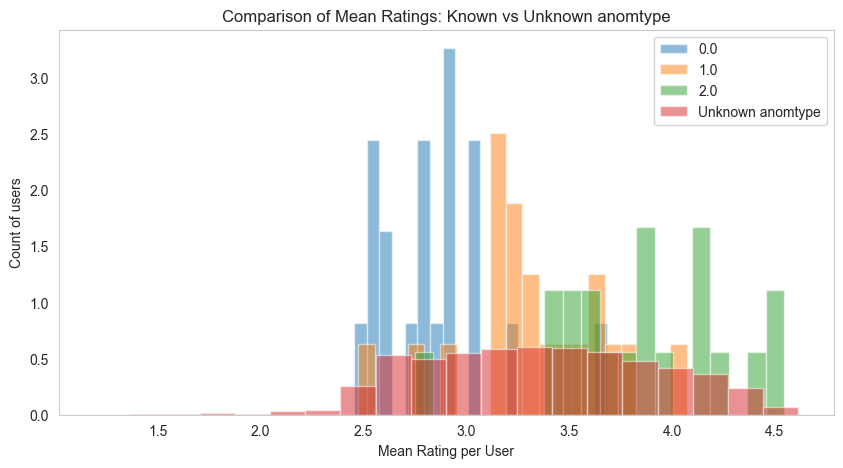

In [102]:
# Comparison of Mean Ratings: Known vs Unknown anomtype

# Compute mean rating per user from X
user_means = X_no_dupes.groupby("user")["rating"].mean().reset_index(name="mean_rating")

# Join with anomtype info
user_means = user_means.merge(y_cat_combined, on="user", how="left")

# Add 'unknown anomtype' to the rows with unknown anomtype
user_means["anomtype"] = user_means["anomtype"].apply(
    lambda x: x if pd.notnull(x) else "Unknown anomtype"
)

display(user_means.head())

plt.figure(figsize=(10, 5))
for group, data in user_means.groupby("anomtype"):
    plt.hist(
        data["mean_rating"], 
        bins=20,
        alpha=0.5,
        density=True,
        label=group)

plt.xlabel("Mean Rating per User")
plt.ylabel("Count of users")
plt.title("Comparison of Mean Ratings: Known vs Unknown anomtype")
plt.legend()
plt.grid()
plt.show()

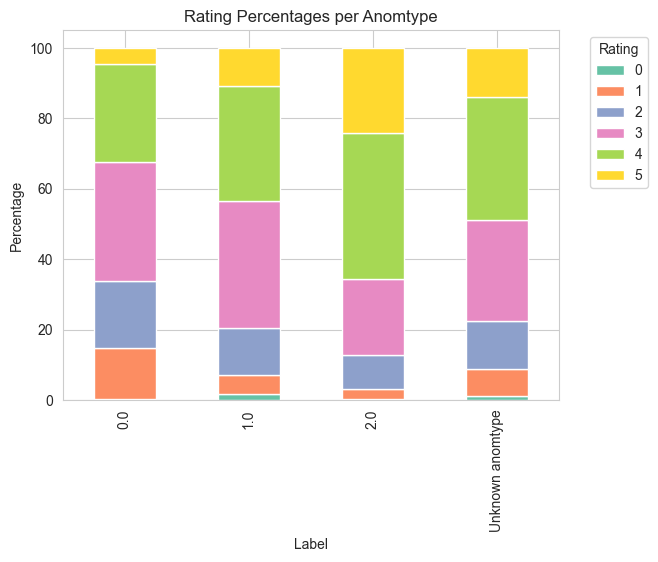

In [103]:
# Rating Percentages per Anomtype

merged_df = pd.merge(X_no_dupes, y_cat_combined, on='user', how='left')
merged_df["anomtype"] = merged_df["anomtype"].apply(
    lambda x: x if pd.notnull(x) else "Unknown anomtype"
)

rating_counts = merged_df.groupby(['anomtype', 'rating']).size().unstack(fill_value=0)
rating_percentages = rating_counts.div(rating_counts.sum(axis=1), axis=0) * 100
rating_percentages.plot(kind='bar', stacked=True, ax=plt.gca(), color=sns.color_palette('Set2'))
plt.title('Rating Percentages per Anomtype')
plt.xlabel('Label')
plt.ylabel('Percentage')
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1))

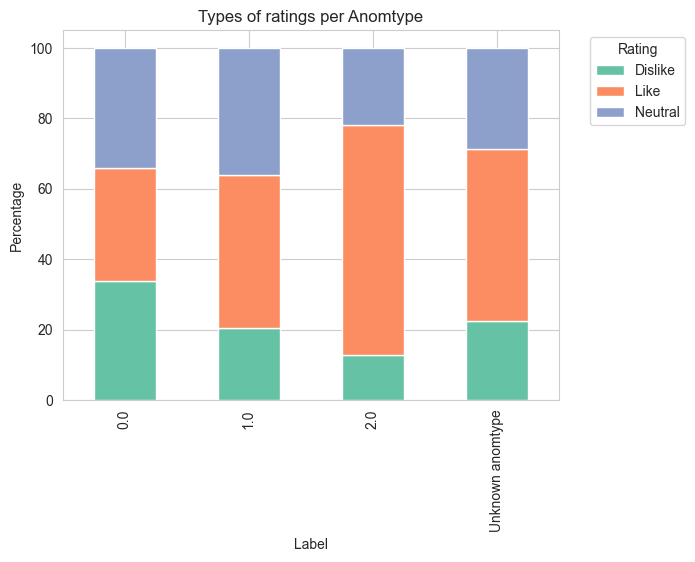

In [104]:
# We now group the ratings into categories of Dislike/Neutral/Like

def map_rating_category(r):
    if r in [0, 1, 2]:
        return "Dislike"
    elif r == 3:
        return "Neutral"
    else: 
        return "Like"

merged_df["rating_category"] = merged_df["rating"].apply(map_rating_category)

rating_counts = merged_df.groupby(['anomtype', 'rating_category']).size().unstack(fill_value=0)
rating_percentages = rating_counts.div(rating_counts.sum(axis=1), axis=0) * 100
rating_percentages.plot(kind='bar', stacked=True, ax=plt.gca(), color=sns.color_palette('Set2'))
plt.title('Types of ratings per Anomtype')
plt.xlabel('Label')
plt.ylabel('Percentage')
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1))

Our hypothesis seems to be true: it is evident from this graph that the different labels have different mean ratings and rating percentages. For example, anomtype 0 has quite a small like percentage compared to that of anomtype 2. 
This suggests the need to create additional features such as `mean_rating` and possibly `like_ratio` /`dislike_ratio` / `neutral_ratio` for our models to more accurately predict the anomtype.

### Creating basic features

In [105]:
# Basic user features
df_user_features = X_no_dupes.groupby("user").agg(
    mean_rating=("rating", "mean"),
    median_rating=("rating", "median"),
    std_rating=("rating", "std"),
    min_rating=("rating", "min"),
    max_rating=("rating", "max"),
    count_dislike=("rating", lambda x: ((x == 0) | (x == 1) | (x == 2)).sum()),
    count_neutral=("rating", lambda x: (x == 3).sum()),
    count_like=("rating", lambda x: ((x == 4) | (x == 5)).sum()),
    total_interactions=("rating", "count"),
)

df_user_features.head()

,mean_rating,median_rating,std_rating,min_rating,max_rating,count_dislike,count_neutral,count_like,total_interactions
user,,,,,,,,,
0,2.435644,2.0,1.145320,1,5,108,45,49,202
1,2.698507,3.0,0.838000,1,5,138,154,43,335
2,3.904580,4.0,0.576070,2,5,1,54,207,262
3,3.801370,4.0,1.084853,0,5,35,50,207,292
4,4.373737,4.0,0.713693,2,5,7,6,185,198


In [106]:
# User mean rank
df_user_features["user_mean_rank"] = df_user_features["mean_rating"].rank(pct=True)

We also included `user_mean_rank`, a simple feature counting the rank of the user's mean ratings, to capture where a user's average rating stands relative to all other users. This could serve as a good baseline for the model to decide which anomtype the user belongs to.

At this juncture, we also hypothesized that we could use another feature `normalized_std` based on these basic user features to increase our performance.  
normalized_std is calculated by `std / mean_rating`, which indicates how much a user's ratings fluctuate relative to their average rating level.

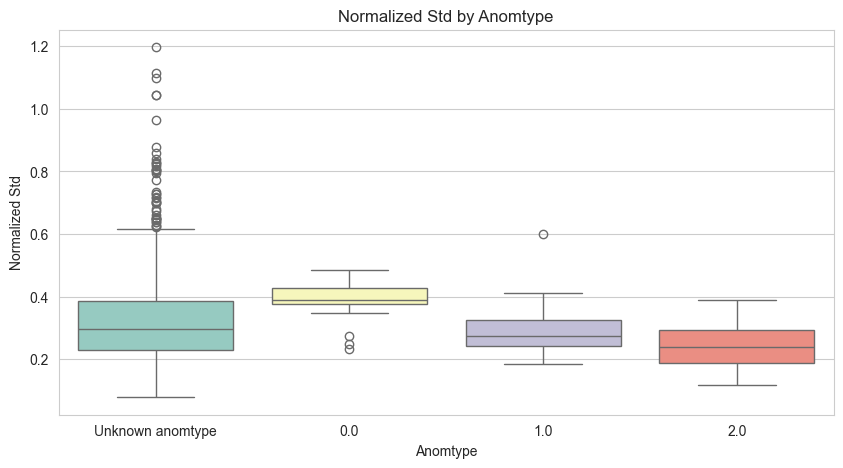

In [107]:
# Normalized Std by Anomaly Type

# Calculate normalized_std
df_user_features["normalized_std"] = ( # NEW
        df_user_features["std_rating"] / (df_user_features["mean_rating"] + 1e-5) # in case the mean_rating is 0
)

# Plot a boxplot of normalized_std against anomtype
test_df = pd.merge(df_user_features, y_cat_combined, on="user", how="left")
test_df["anomtype"] = test_df["anomtype"].apply(
    lambda x: x if pd.notnull(x) else "Unknown anomtype"
)

plt.figure(figsize=(10, 5))
sns.boxplot(
    data=test_df,
    x='anomtype',
    y='normalized_std',
    palette='Set3'
)
plt.title("Normalized Std by Anomtype")
plt.xlabel("Anomtype")
plt.ylabel("Normalized Std")
plt.grid(True, axis='y')
plt.show()

The `normalized_std` feature is quite discriminative, showing that the different anomtypes have clearly different medians. We thus confirm adding it to our engineered features. 

### Ratio features
We first plot the number of ratings per user, week by week.

Text(0, 0.5, 'Frequency')

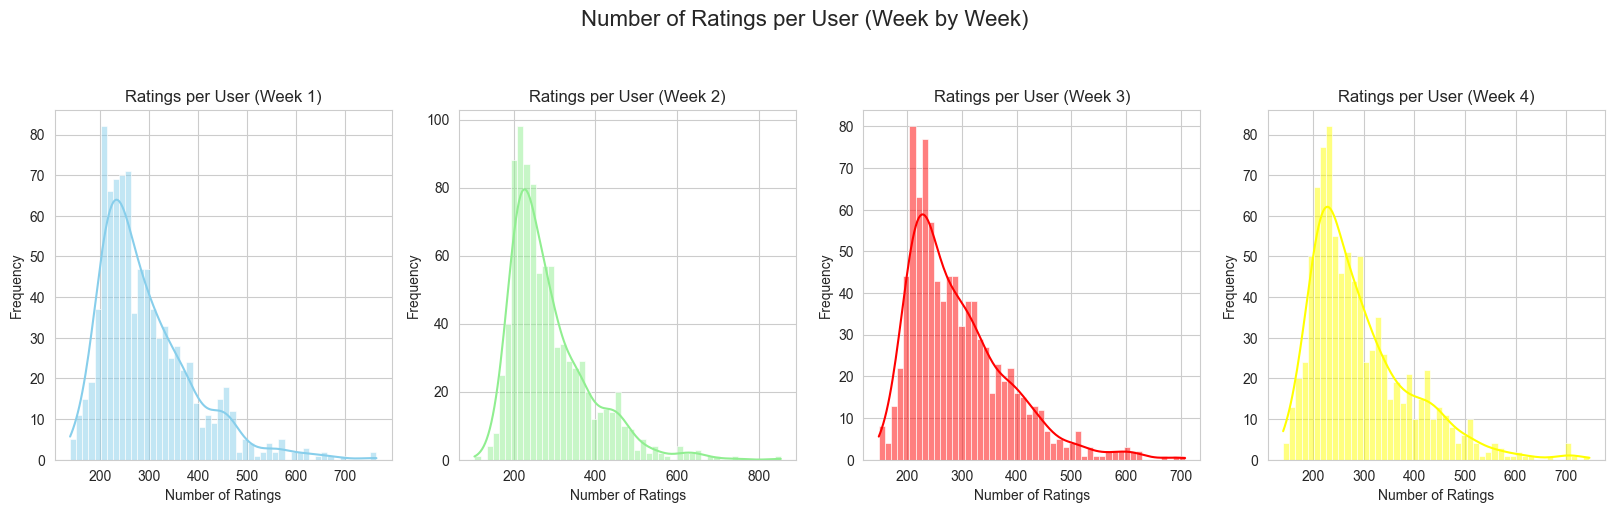

In [108]:
# Number of Ratings per User

user_ratings = X_no_dupes.groupby(['batch', 'user']).size().reset_index(name='rating_count')
item_ratings = X_no_dupes.groupby(['batch', 'item']).size().reset_index(name='rating_count')

# Create the second dashboard with a 3x1 grid
fig2 = plt.figure(figsize=(20, 10))
fig2.suptitle("Number of Ratings per User (Week by Week)", fontsize=16, y=0.98)

# Week 1
plt.subplot(2, 4, 1)
sns.histplot(data=user_ratings[user_ratings['batch'] == 'Week 1'], x='rating_count', bins=50, kde=True, color='skyblue')
plt.title('Ratings per User (Week 1)')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')

# Week 2
plt.subplot(2, 4, 2)
sns.histplot(data=user_ratings[user_ratings['batch'] == 'Week 2'], x='rating_count', bins=50, kde=True, color='lightgreen')
plt.title('Ratings per User (Week 2)')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')

# Week 3
plt.subplot(2, 4, 3)
sns.histplot(data=user_ratings[user_ratings['batch'] == 'Week 3'], x='rating_count', bins=50, kde=True, color='red')
plt.title('Ratings per User (Week 3)')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')

# Week 4
plt.subplot(2, 4, 4)
sns.histplot(data=user_ratings[user_ratings['batch'] == 'Week 4'], x='rating_count', bins=50, kde=True, color='yellow')
plt.title('Ratings per User (Week 4)')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')

A skewed distribution (many users with few interactions, few with many) further suggests that we need to create additional features such as ratios (like_ratio, dislike_ratio) to account for varying activity levels.  
We first plot a simple boxplot to check it out.

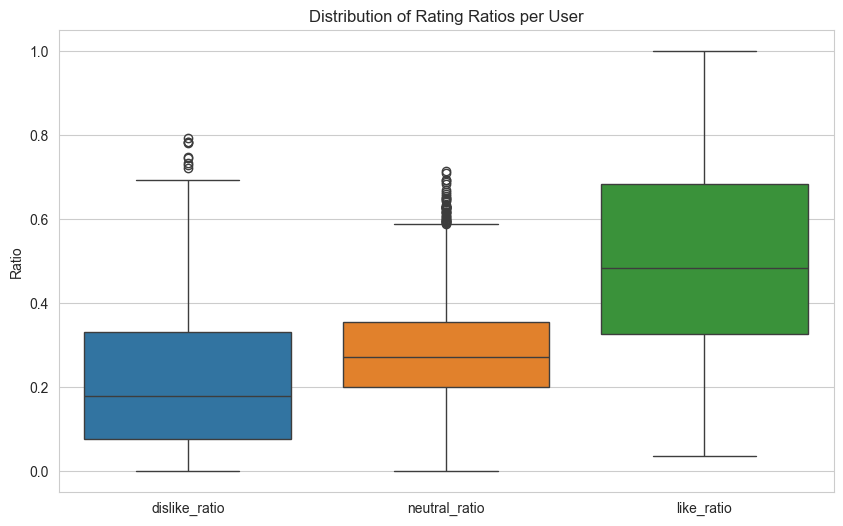

In [109]:
# Distribution of rating ratios per User

# Calculate counts per user for specific ratings
user_rating_counts = X_no_dupes.groupby('user')['rating'].agg(
    dislike=lambda x: ((x == 0) | (x == 1) | (x == 2)).sum(),
    neutral=lambda x: (x == 3).sum(),
    like=lambda x: ((x == 4) | (x == 5)).sum()
).reset_index()

# Calculate ratios (relative to total interactions)
user_total = X_no_dupes.groupby('user')['rating'].count().reset_index(name='total')
user_rating_ratios = pd.merge(user_rating_counts, user_total, on='user')
for col in ['dislike', 'neutral', 'like']:
    user_rating_ratios[f'{col}_ratio'] = user_rating_ratios[col] / user_rating_ratios['total']

# Boxplot of ratios
plt.figure(figsize=(10, 6))
sns.boxplot(data=user_rating_ratios[['dislike_ratio', 'neutral_ratio', 'like_ratio']])
plt.title('Distribution of Rating Ratios per User')
plt.ylabel('Ratio')
plt.show()

There are an extreme number of outliers in both `dislike_ratio` and `neutral_ratio` which suggests they capture distinctive user patterns.  
If these extreme values correspond to meaningful class differences (anomtype), including this feature could help improve the accuracy of our model.

### Creating Ratio features

In [110]:
df_user_features["like_ratio"] = (
    df_user_features["count_like"] / df_user_features["total_interactions"]
)
df_user_features["dislike_ratio"] = (
    df_user_features["count_dislike"] / df_user_features["total_interactions"]
)
df_user_features["neutral_ratio"] = (
    df_user_features["count_neutral"] / df_user_features["total_interactions"]
)

num_items = X_no_dupes["item"].nunique()
df_user_features["interaction_ratio"] = df_user_features["total_interactions"] / num_items

display(df_user_features)

,mean_rating,median_rating,std_rating,min_rating,max_rating,count_dislike,count_neutral,count_like,total_interactions,user_mean_rank,normalized_std,like_ratio,dislike_ratio,neutral_ratio,interaction_ratio
user,,,,,,,,,,,,,,,
0,2.435644,2.0,1.145320,1,5,108,45,49,202,0.023611,0.470231,0.242574,0.534653,0.222772,0.202
1,2.698507,3.0,0.838000,1,5,138,154,43,335,0.131667,0.310541,0.128358,0.411940,0.459701,0.335
2,3.904580,4.0,0.576070,2,5,1,54,207,262,0.804722,0.147537,0.790076,0.003817,0.206107,0.262
3,3.801370,4.0,1.084853,0,5,35,50,207,292,0.752222,0.285384,0.708904,0.119863,0.171233,0.292
4,4.373737,4.0,0.713693,2,5,7,6,185,198,0.971667,0.163177,0.934343,0.035354,0.030303,0.198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,3.302521,3.0,0.950724,0,5,40,82,116,238,0.467222,0.287877,0.487395,0.168067,0.344538,0.238
3596,3.923423,4.0,1.112858,0,5,21,27,174,222,0.812778,0.283644,0.783784,0.094595,0.121622,0.222
3597,3.936455,4.0,1.128925,0,5,27,41,231,299,0.817778,0.286787,0.772575,0.090301,0.137124,0.299


### Weighted Score features
We plotted a simple scatter plot to observe the likes vs dislikes per user, to see if we can find any features to classify anomtypes.

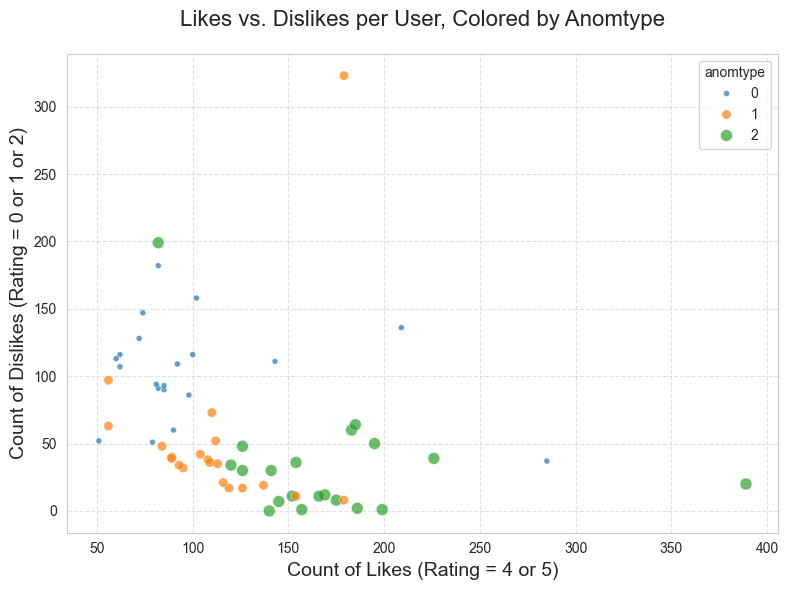

In [111]:
# Likes vs Dislikes per User, Colored by Anomtype

# Compute user-level counts
user_counts = X_no_dupes.groupby("user").agg(
    count_like=("rating", lambda x: ((x == 4) | (x == 5)).sum()),
    count_dislike=("rating", lambda x: ((x == 0) | (x == 1) | (x == 2)).sum())
)

# Merge with the target labels (y)
df_plot = pd.merge(user_counts.reset_index(), y_cat_combined, on="user")

# Create a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_plot,
    x="count_like",
    y="count_dislike",
    hue="anomtype",
    size="anomtype",
    palette="tab10",
    alpha=0.7,
)
plt.title("Likes vs. Dislikes per User, Colored by Anomtype", fontsize=16, pad=20)
plt.xlabel("Count of Likes (Rating = 4 or 5)", fontsize=14)
plt.ylabel("Count of Dislikes (Rating = 0 or 1 or 2)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

Apart from a few outliers, we can somewhat see that there are 3 main groups: 
1) Anomtype 0 in the middle left quadrant, with high number of dislikes and low number of likes
2) Anomtype 1 in the bottom left quadrant, with low number of both dislikes and likes
3) Anomtype 2 in the middle right quadrant, with a high number of likes and low number of dislikes

This suggests that the balance between likes and dislikes is related to the anomtype, and could help the model differentiate between the different anomtypes.  
We try to use weighted score to amplify the impact of these extremes to see if we can better distinguish the anomtypes.

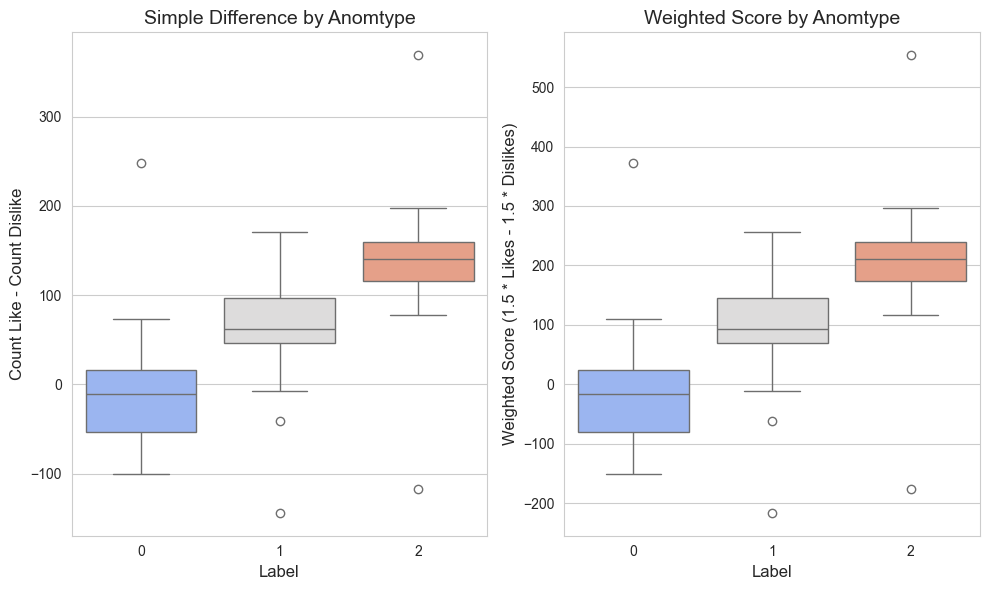

In [112]:
# Compute the simple difference and weighted score
df_plot["simple_diff"] = df_plot["count_like"] - df_plot["count_dislike"]
df_plot["weighted_score"] = df_plot["count_like"] * 1.5 - df_plot["count_dislike"] * 1.5

# Plot boxplots to compare
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x="anomtype", y="simple_diff", data=df_plot, palette="coolwarm")
plt.title("Simple Difference by Anomtype", fontsize=14)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Count Like - Count Dislike", fontsize=12)

plt.subplot(1, 2, 2)
sns.boxplot(x="anomtype", y="weighted_score", data=df_plot, palette="coolwarm")
plt.title("Weighted Score by Anomtype", fontsize=14)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Weighted Score (1.5 * Likes - 1.5 * Dislikes)", fontsize=12)

plt.tight_layout()
plt.show()

The two boxplots compare the distribution of user sentiment metrics across different label values. From the plot, we can see the y-axis from both plots have different ranges, due to one of them having the weighting factor. The weighted score plot on the right shows slightly better separation between labels, with less overlap in the IQR, which suggests that the weighting amplifies the differences in sentiment, making it a more discriminative feature for distinguishing between labels.

We could use this as a feature to try to enhance the ability to capture the polarity of user preferences.

### Creating Weighted Score features

In [113]:
df_user_features["weighted_score"] = df_user_features["count_like"] * 1.5 - df_user_features["count_dislike"] * 1.5
df_user_features.head()

,mean_rating,median_rating,std_rating,min_rating,max_rating,count_dislike,count_neutral,count_like,total_interactions,user_mean_rank,normalized_std,like_ratio,dislike_ratio,neutral_ratio,interaction_ratio,weighted_score
user,,,,,,,,,,,,,,,,
0,2.435644,2.0,1.145320,1,5,108,45,49,202,0.023611,0.470231,0.242574,0.534653,0.222772,0.202,-88.5
1,2.698507,3.0,0.838000,1,5,138,154,43,335,0.131667,0.310541,0.128358,0.411940,0.459701,0.335,-142.5
2,3.904580,4.0,0.576070,2,5,1,54,207,262,0.804722,0.147537,0.790076,0.003817,0.206107,0.262,309.0
3,3.801370,4.0,1.084853,0,5,35,50,207,292,0.752222,0.285384,0.708904,0.119863,0.171233,0.292,258.0
4,4.373737,4.0,0.713693,2,5,7,6,185,198,0.971667,0.163177,0.934343,0.035354,0.030303,0.198,267.0


### Distribution features
We did some research and found that kurtosis and skewness are two useful features we could use to describe the distribution of ratings within a user.

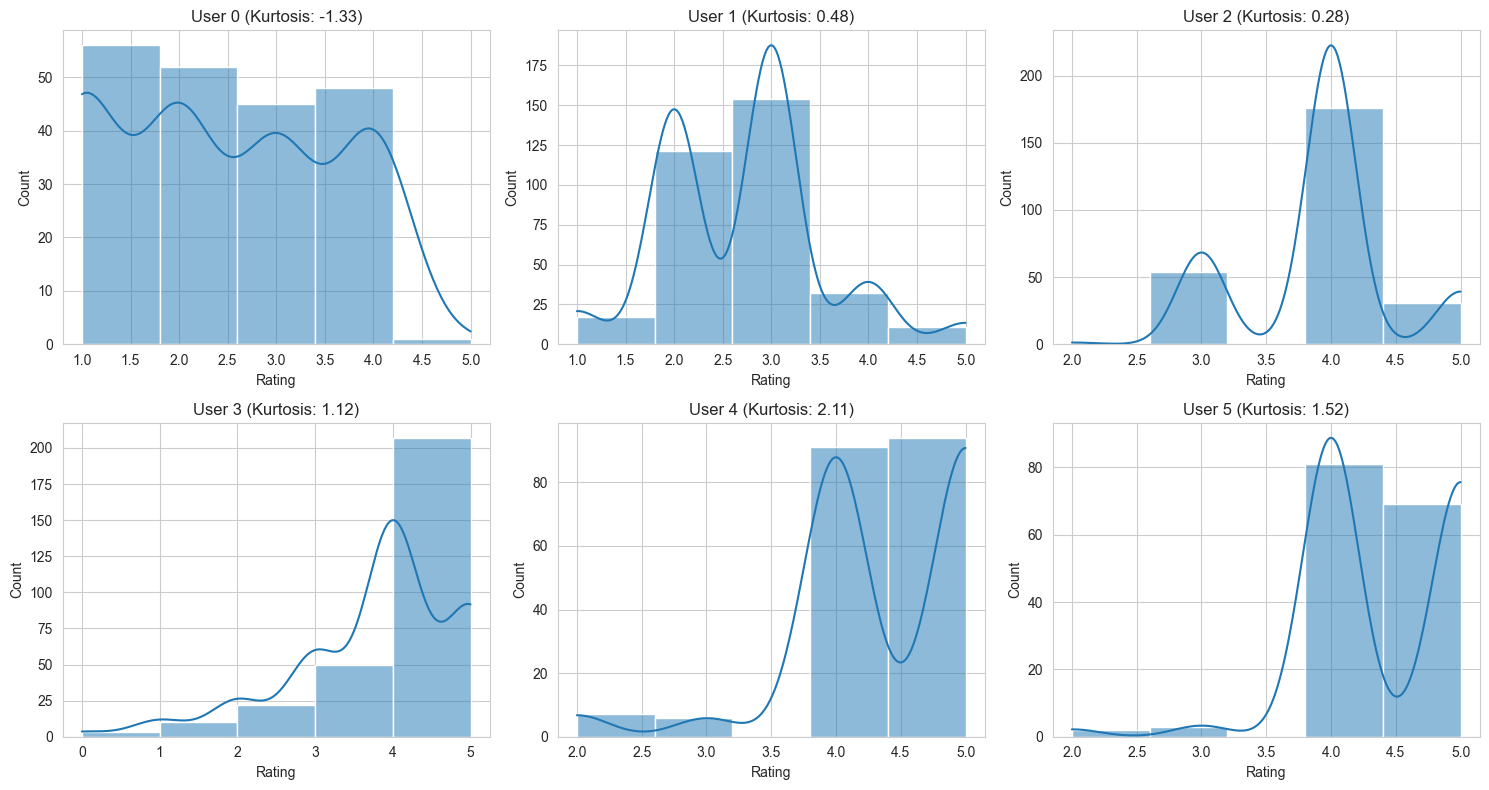

In [114]:
# Select a sample of users (e.g., last 6 users)
sample_users = X_no_dupes["user"].unique()[:6]

# Plot histograms of ratings for each user
plt.figure(figsize=(15, 8))
for i, user in enumerate(sample_users, 1):
    plt.subplot(2, 3, i)
    user_ratings = X_no_dupes[X_no_dupes["user"] == user]["rating"]
    sns.histplot(user_ratings, bins=5, kde=True)
    plt.title(f"User {user} (Kurtosis: {kurtosis(user_ratings):.2f})")
    plt.xlabel("Rating")
    plt.ylabel("Count")
plt.tight_layout()
plt.show()

Kurtosis is a statistical measure that describes the "tailedness" or shape of a distribution, particularly how much of the data is concentrated in the tails (extreme values) compared to the center. This feature captures the shape of a user’s rating distribution, which can reveal behavioral patterns that other features (like mean_rating or count_like) might miss.

Columns in df_kurtosis: Index(['user', 'rating_kurtosis'], dtype='object')
   user  rating_kurtosis
0     0        -1.329120
1     1         0.483190
2     2         0.281598
3     3         1.122078
4     4         2.109801


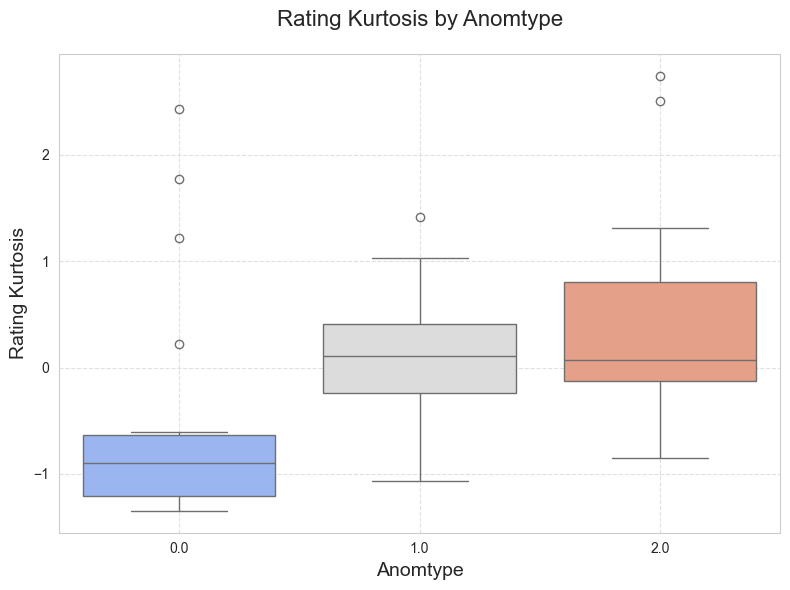

In [115]:
# Compute kurtosis for each user
user_kurtosis = X_no_dupes.groupby("user")["rating"].apply(lambda x: kurtosis(x)).fillna(0)

# Convert the Series to a DataFrame with the correct structure
df_kurtosis = pd.DataFrame({
    "user": user_kurtosis.index,
    "rating_kurtosis": user_kurtosis.values
})

# Verify the DataFrame
print("Columns in df_kurtosis:", df_kurtosis.columns)
print(df_kurtosis.head())

# Merge with the target labels (y)
df_plot = pd.merge(df_kurtosis, y_cat_combined, on="user", how="left")

# Create a boxplot of kurtosis by anomtype
plt.figure(figsize=(8, 6))
sns.boxplot(x="anomtype", y="rating_kurtosis", data=df_plot, palette="coolwarm")
plt.title("Rating Kurtosis by Anomtype", fontsize=16, pad=20)
plt.xlabel("Anomtype", fontsize=14)
plt.ylabel("Rating Kurtosis", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

It is quite clear that there are varying levels of Kurtosis for each different label (especially 0 vs 1 and 2), so this could also be a useful factor in increasing accuracy of our models.

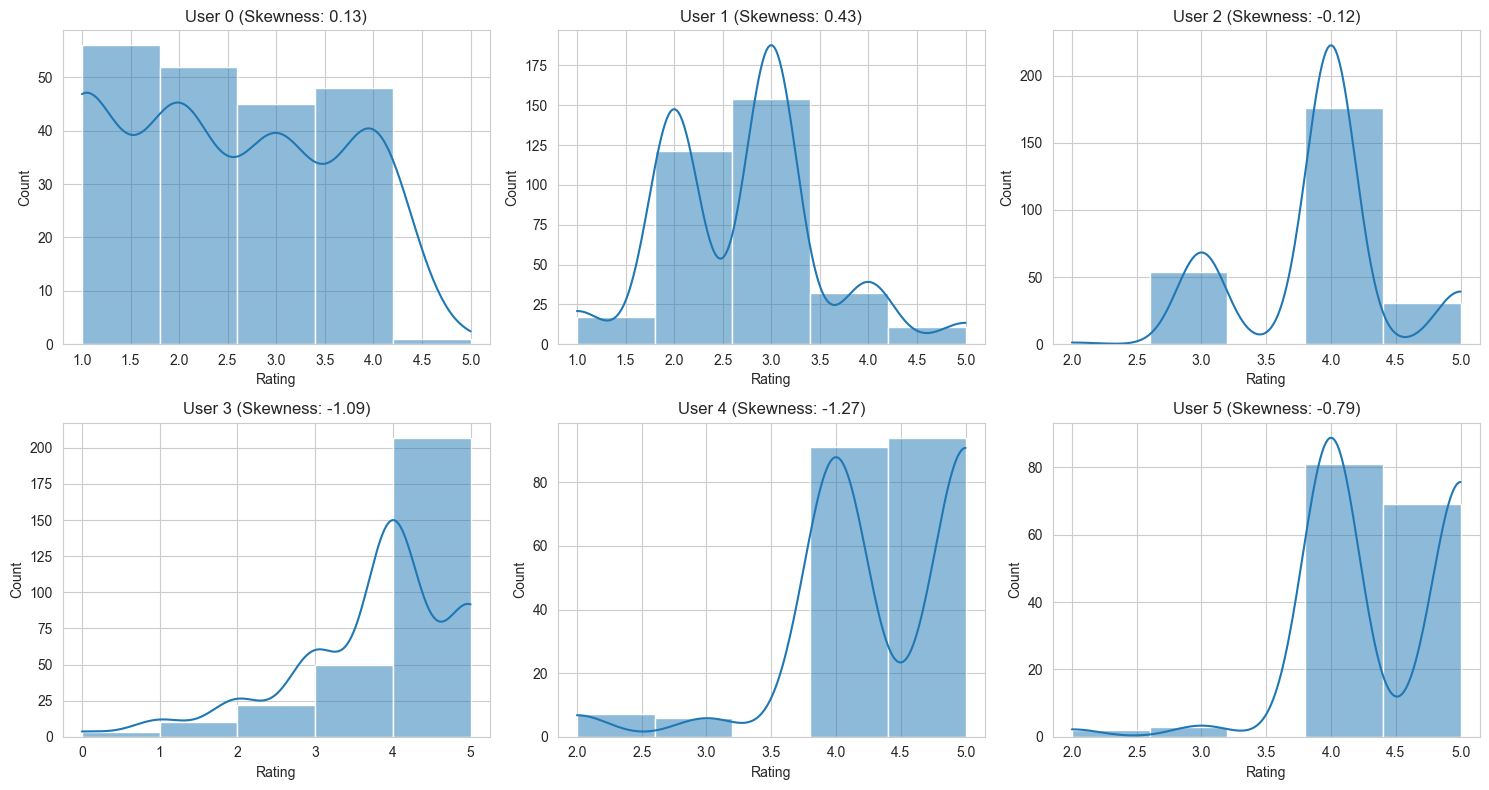

In [116]:
# Select a sample of users (e.g., last 6 users)
sample_users = X_no_dupes["user"].unique()[:6]

# Plot histograms of ratings for each user with skewness in title
plt.figure(figsize=(15, 8))
for i, user in enumerate(sample_users, 1):
    plt.subplot(2, 3, i)
    user_ratings = X_no_dupes[X_no_dupes["user"] == user]["rating"]
    sns.histplot(user_ratings, bins=5, kde=True)
    plt.title(f"User {user} (Skewness: {skew(user_ratings):.2f})")
    plt.xlabel("Rating")
    plt.ylabel("Count")
plt.tight_layout()
plt.show()

Skewness measures the asymmetry of a user’s rating distribution — whether their ratings are more heavily concentrated toward the lower or higher end of the scale.  
A positive skewness indicates that a user tends to give mostly low ratings with occasional high ones, while a negative skewness indicates a preference for high ratings with few low scores.  
This feature helps uncover user-specific rating tendencies and biases that aren’t captured by simple averages.  
For example, a user who frequently gives extreme low ratings may represent a stricter or more negative behavior pattern, while a user with negative skew (many high ratings) may represent lenient or overly positive behavior.  
When compared across anomaly types, skewness can reveal distinct rating biases or inconsistencies that correlate with noisy or anomalous behavior.

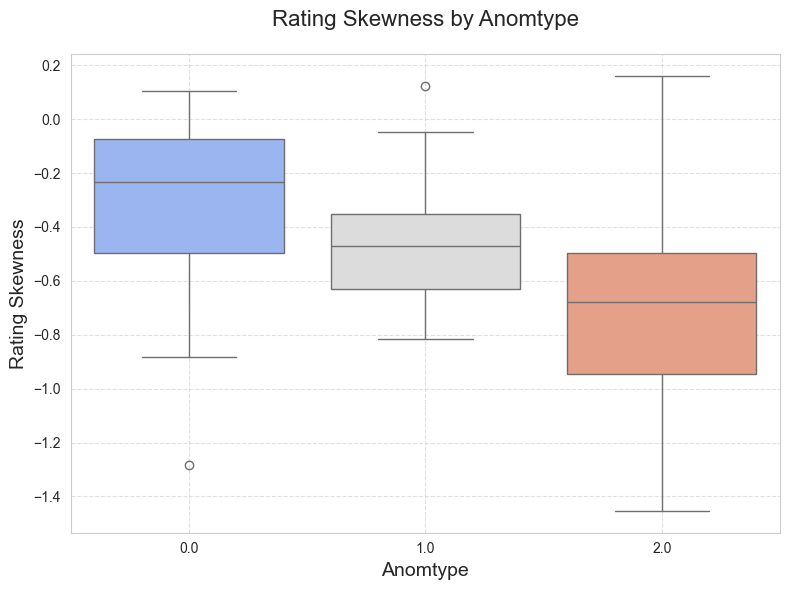

In [117]:
# Compute skewness for each user
user_skewness = X_no_dupes.groupby("user")["rating"].apply(lambda x: skew(x)).fillna(0)

# Convert Series to DataFrame
df_skewness = pd.DataFrame({
    "user": user_skewness.index,
    "rating_skewness": user_skewness.values
})

# Merge with target labels
df_plot = pd.merge(df_skewness, y_cat_combined, on="user", how="left")

# Create boxplot of skewness by anomtype
plt.figure(figsize=(8, 6))
sns.boxplot(x="anomtype", y="rating_skewness", data=df_plot, palette="coolwarm")
plt.title("Rating Skewness by Anomtype", fontsize=16, pad=20)
plt.xlabel("Anomtype", fontsize=14)
plt.ylabel("Rating Skewness", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

It is also quite clear that rating skewness is discriminative, so we choose to use it in our feature set.

### Creating Distribution features

In [118]:
df_user_features["rating_kurtosis"] = X_no_dupes.groupby("user")["rating"].apply(
    kurtosis
)
df_user_features["rating_skewness"] = X_no_dupes.groupby("user")["rating"].apply(
    skew
)

df_user_features.head()

,mean_rating,median_rating,std_rating,min_rating,max_rating,count_dislike,count_neutral,count_like,total_interactions,user_mean_rank,normalized_std,like_ratio,dislike_ratio,neutral_ratio,interaction_ratio,weighted_score,rating_kurtosis,rating_skewness
user,,,,,,,,,,,,,,,,,,
0,2.435644,2.0,1.145320,1,5,108,45,49,202,0.023611,0.470231,0.242574,0.534653,0.222772,0.202,-88.5,-1.329120,0.128503
1,2.698507,3.0,0.838000,1,5,138,154,43,335,0.131667,0.310541,0.128358,0.411940,0.459701,0.335,-142.5,0.483190,0.429664
2,3.904580,4.0,0.576070,2,5,1,54,207,262,0.804722,0.147537,0.790076,0.003817,0.206107,0.262,309.0,0.281598,-0.120041
3,3.801370,4.0,1.084853,0,5,35,50,207,292,0.752222,0.285384,0.708904,0.119863,0.171233,0.292,258.0,1.122078,-1.088240
4,4.373737,4.0,0.713693,2,5,7,6,185,198,0.971667,0.163177,0.934343,0.035354,0.030303,0.198,267.0,2.109801,-1.271711


### User bias feature
User bias measures how much a user’s ratings systematically deviate from the average rating given to the same items by everyone else.  
It quantifies how lenient or strict a user is, compared to the crowd.  
We chose this feature as it can help us detect users who consistently overrate or underrate items compared to the majority.

In [119]:
# Compute the average rating per item
item_means = X_no_dupes.groupby("item")["rating"].mean().rename("item_mean")

# Merge the item mean back into the main dataframe to associate each user-item pair with its item's average rating
df_tmp = X_no_dupes.merge(item_means, on="item", how="left")

# Compute user bias: the average of how much the user's rating deviates from the item mean
user_bias = df_tmp.groupby("user").apply(
    lambda df: (df["rating"] - df["item_mean"]).mean()
).rename("user_bias")
df_tmp = df_tmp.merge(user_bias, on="user", how="left")

# Merge with known and unknown anomtypes
df_tmp = pd.merge(df_tmp, y_cat_combined, on='user', how='left')
df_tmp["anomtype"] = df_tmp["anomtype"].apply(
    lambda x: x if pd.notnull(x) else "Unknown anomtype"
)

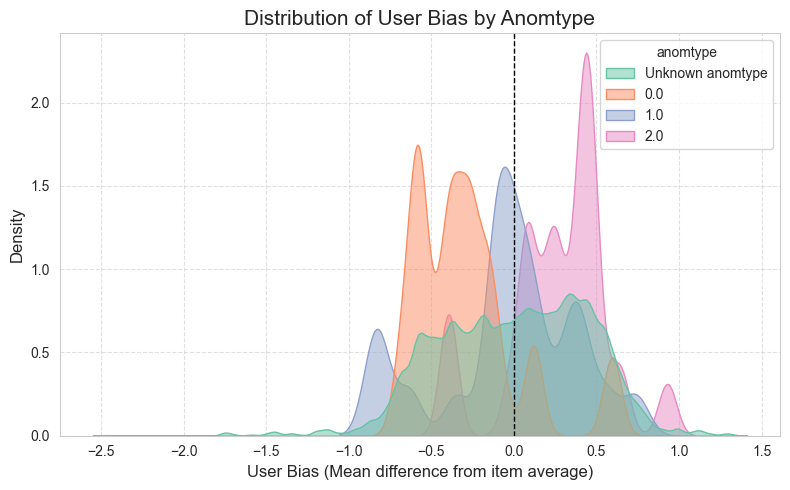

In [120]:
# Distribution of User Bias by Anomtype

plt.figure(figsize=(8, 5))
sns.kdeplot(
    data=df_tmp,
    x="user_bias",
    hue="anomtype",
    fill=True,
    common_norm=False,
    palette="Set2",
    alpha=0.5
)
plt.title("Distribution of User Bias by Anomtype", fontsize=15)
plt.xlabel("User Bias (Mean difference from item average)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


From this graph, we can clearly see that the three anomtypes are clearly divided:  
* anomtype 0 seems to underrate  
* anomtype 1 seems to be normally distributed around 0
* anomtype 2 seems to overrate.

We thus keep `user_bias` as a feature in our feature set.

### Mean item alignment
Mean item alignment measures how closely a user's ratings align with the general consensus for each item, but expressed in standardized (z-score) units. As a feature, it is similar to user bias, but it is normalized by each item's rating variance.  
Both are complementary: Mean item alignment highlights relative consistency with item consensus, but user bias captures systematic optimism or harshness in a user's rating tendencies.


In [121]:
# Recompute average rating and std per item
item_stats = X_no_dupes.groupby("item")["rating"].agg(["mean", "std"]).rename(
    columns={"mean": "item_mean", "std": "item_std"}
)

# Add them to the dataset
df_tmp = X_no_dupes.merge(item_stats, on="item", how="left")

# Using average rating and std, compute mean_item_alignment
df_tmp["z_score_item"] = (df_tmp["rating"] - df_tmp["item_mean"]) / (
    df_tmp["item_std"] + 1e-6
)
mean_item_alignment = df_tmp.groupby("user")["z_score_item"].mean().rename(
    "mean_item_alignment"
)
df_tmp = df_user_features.merge(mean_item_alignment, on="user", how="left")

# Merge with known and unknown anomtypes
df_tmp = pd.merge(df_tmp, y_cat_combined, on='user', how='left')
df_tmp["anomtype"] = df_tmp["anomtype"].apply(
    lambda x: x if pd.notnull(x) else "Unknown anomtype"
)

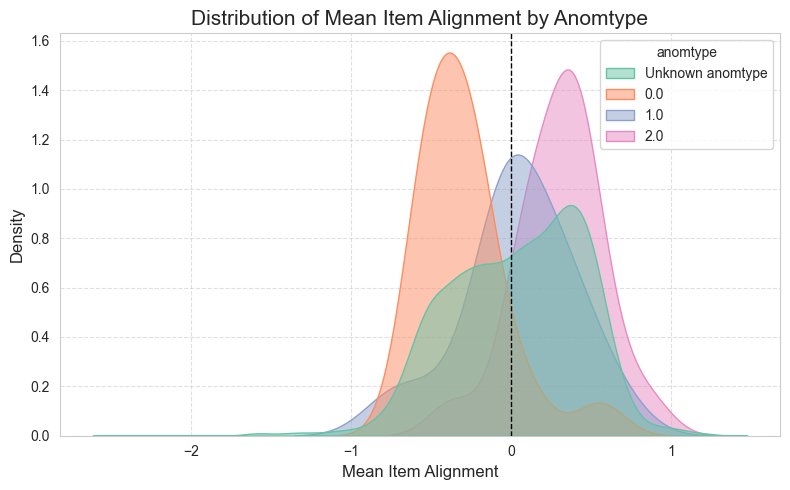

In [122]:
# Distribution of mean item alignment by anomtype

plt.figure(figsize=(8, 5))
sns.kdeplot(
    data=df_tmp,
    x="mean_item_alignment",
    hue="anomtype",
    fill=True,
    common_norm=False,
    palette="Set2",
    alpha=0.5
)
plt.title("Distribution of Mean Item Alignment by Anomtype", fontsize=15)
plt.xlabel("Mean Item Alignment", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


This graph of `mean_item_alignment` is basically a smoother version of the one above, and may help our model better differentiate between the different anomtypes.  
We thus choose to add it into our feature set.

### Outlier feature
We first plot the number of outliers each user has, to see how unusual a user's ratings are compared to other users' ratings for the same items.

In [123]:
# Recompute average rating and std per item
item_stats = X_no_dupes.groupby("item")["rating"].agg(["mean", "std"]).rename(
    columns={"mean": "item_mean", "std": "item_std"}
)
df_tmp = X_no_dupes.merge(item_stats, on="item", how="left")

# Calculate the absolute deviation from the item mean
df_tmp["abs_dev"] = abs(df_tmp["rating"] - df_tmp["item_mean"])

# Calculate fraction of outliers over overall ratings
# Outliers are calculated as abs_dev > 1.5 * item_std
outlier_frac = (df_tmp["abs_dev"] > 1.5 * df_tmp["item_std"]).groupby(
    df_tmp["user"]
).mean().rename("outlier_frac")

df_tmp = df_user_features.merge(outlier_frac, on="user", how="left")

# Merge with known and unknown anomtypes
df_tmp = pd.merge(df_tmp, y_cat_combined, on='user', how='left')
df_tmp["anomtype"] = df_tmp["anomtype"].apply(
    lambda x: x if pd.notnull(x) else "Unknown anomtype"
)

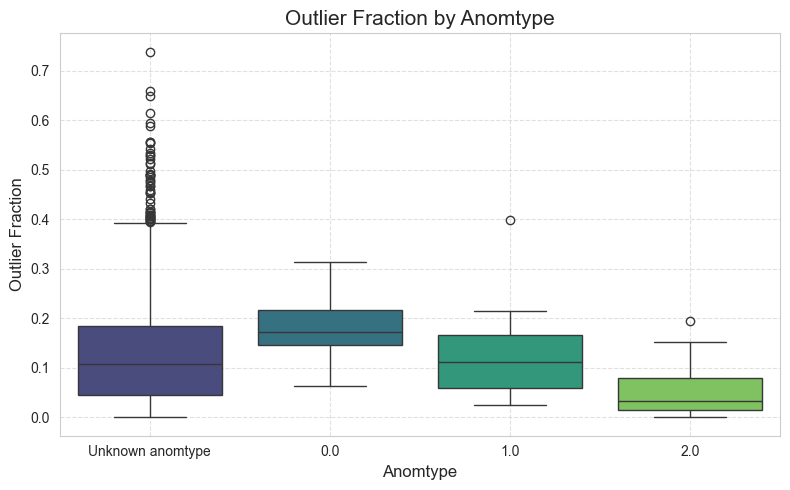

In [124]:
# Outlier fraction by Anomtype

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_tmp,
    x="anomtype",
    y="outlier_frac",
    palette="viridis"
)
plt.title("Outlier Fraction by Anomtype", fontsize=15)
plt.xlabel("Anomtype", fontsize=12)
plt.ylabel("Outlier Fraction", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

This `outlier_frac` feature is discriminative: it can show that anomaly type 0 has more outliers than usual, and anomaly type 2 has barely any outliers.  
We thus choose to add it into our feature set.

### Creating user bias, outlier, mean item alignment features

In [125]:
df_user_features = df_user_features.merge(user_bias, on="user", how="left")
df_user_features = df_user_features.merge(mean_item_alignment, on="user", how="left")
df_user_features = df_user_features.merge(outlier_frac, on="user", how="left")

### Rating volatility [NOT USED IN FINAL]
Rating volatility quantifies how much a user’s ratings fluctuate between consecutive items, providing a measure of their internal consistency.  
Unlike features such as user bias or mean item alignment, which compare a user’s ratings against the broader community consensus for each item, rating volatility captures variability within the user’s own rating behavior.  
It is computed as the average absolute difference between consecutive ratings, reflecting how stable or erratic a user’s preferences are.  
Users with low volatility tend to rate items in a consistent, predictable manner, while those with high volatility exhibit irregular or inconsistent patterns — a strong indicator of potential noise or unreliable rating behavior.

In [126]:
# Calculate rating volatility
user_rating_changes = X_no_dupes.sort_values(["user", "item"]).groupby("user")["rating"].apply(
    lambda x: (x.diff().abs().mean()) if len(x) > 1 else 0
).rename("rating_volatility")

df_tmp = df_user_features.merge(user_rating_changes, on="user", how="left")

# Merge with known and unknown anomtypes
df_tmp = pd.merge(df_tmp, y_cat_combined, on='user', how='left')
df_tmp["anomtype"] = df_tmp["anomtype"].apply(
    lambda x: x if pd.notnull(x) else "Unknown anomtype"
)

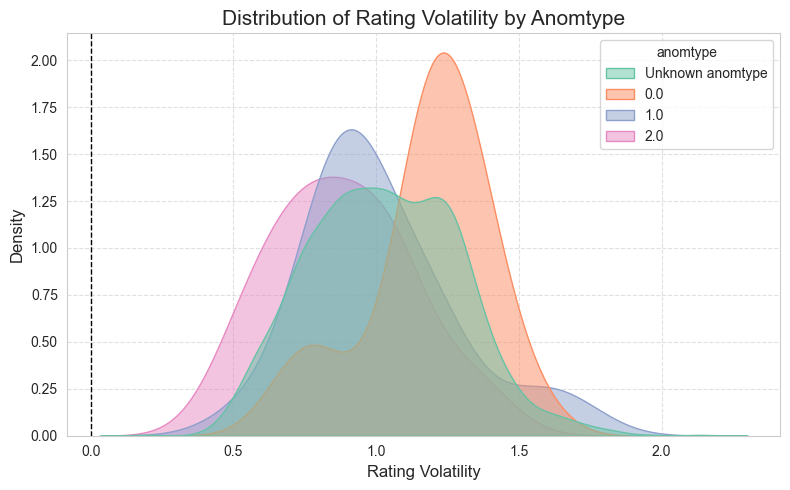

In [127]:
# Distribution of rating volatility by Anomtype

plt.figure(figsize=(8, 5))
sns.kdeplot(
    data=df_tmp,
    x="rating_volatility",
    hue="anomtype",
    fill=True,
    common_norm=False,
    palette="Set2",
    alpha=0.5
)

plt.title("Distribution of Rating Volatility by Anomtype", fontsize=15)
plt.xlabel("Rating Volatility", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

The graph shows 3 humps for each anomtype, but they are quite closely overlapping with one another, hence we choose not to use it in our feature set.

### Entropy and extreme ratio features 
Building on the idea of outliers, we check for rating entropy, which is the unpredictability or diversity of a user's rating distribution. A high entropy value indicates that the user gives a wide variety of ratings (e.g. evenly using 1-5), while a low entropy value means the user tends to stick to a narrow range of scores. This can help capture how consistently or unrpedictably a user rates items, where unusually high or low entropy can signal atypical or noisy behaviour.

In [128]:
# Calculate rating entropy
user_entropy = X_no_dupes.groupby("user")["rating"].apply(
    lambda x: entropy(x.value_counts(normalize=True))
).rename("rating_entropy")

df_tmp = df_user_features.merge(user_entropy, on="user", how="left")

# Merge with known and unknown anomtypes
df_tmp = pd.merge(df_tmp, y_cat_combined, on='user', how='left')
df_tmp["anomtype"] = df_tmp["anomtype"].apply(
    lambda x: x if pd.notnull(x) else "Unknown anomtype"
)

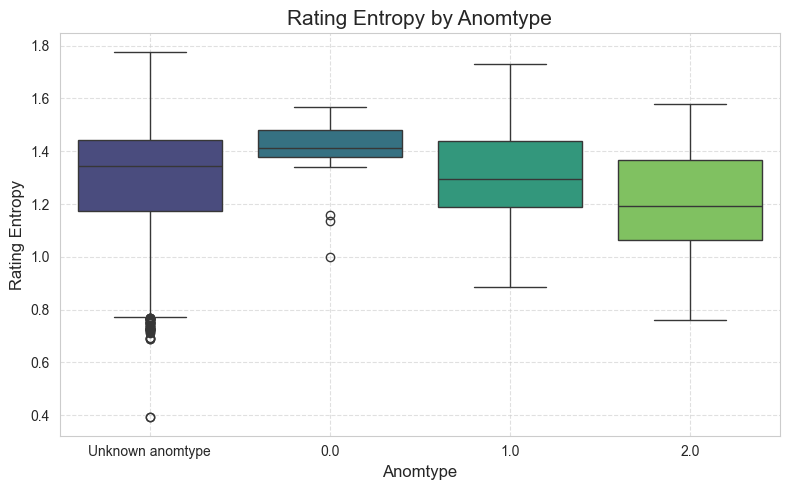

In [129]:
# Rating entropy by Anomtype

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_tmp,
    x="anomtype",
    y="rating_entropy",
    palette="viridis"
)
plt.title("Rating Entropy by Anomtype", fontsize=15)
plt.xlabel("Anomtype", fontsize=12)
plt.ylabel("Rating Entropy", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

Each anomaly type shows noticeably different median rating entropy levels, hence `rating_entropy` provides discriminative information about user behavior.

Extreme ratio refers to the proportion of a user's ratings that are at the extremes of the scale e.g. 1 or 5. It reflects how often a user gives very low or very high scores, indicating polarized rating behaviour. Users with a high extreme ratio might have artifically inflated/deflated ratings, which may be where our anomtypes are derived from.

In [130]:
# Calculate extreme ratio
extreme_ratio = X_no_dupes.groupby("user").apply(
    lambda df: ((df["rating"] == 1) | (df["rating"] == 5)).mean()
).rename("extreme_ratio")

df_tmp = df_user_features.merge(extreme_ratio, on="user", how="left")

# Merge with known and unknown anomtypes
df_tmp = pd.merge(df_tmp, y_cat_combined, on='user', how='left')
df_tmp["anomtype"] = df_tmp["anomtype"].apply(
    lambda x: x if pd.notnull(x) else "Unknown anomtype"
)

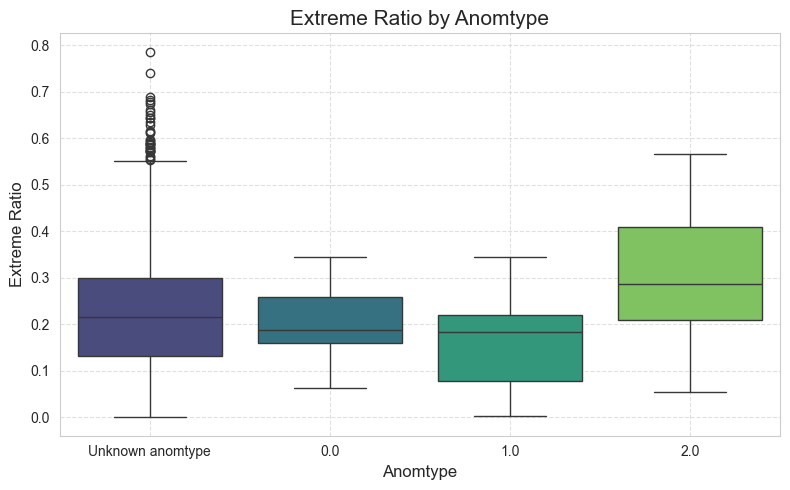

In [131]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_tmp,
    x="anomtype",
    y="extreme_ratio",
    palette="viridis"
)
plt.title("Extreme Ratio by Anomtype", fontsize=15)
plt.xlabel("Anomtype", fontsize=12)
plt.ylabel("Extreme Ratio", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

Each anomaly type shows noticeably different levels of `extreme_ratio`, hence `extreme_ratio` provides discriminative information about user behavior.

We add both entropy and extreme ratio features into our feature set.

In [132]:
df_user_features = df_user_features.merge(user_entropy, on="user", how="left")
df_user_features = df_user_features.merge(extreme_ratio, on="user", how="left")

### Item popularity features [NOT USED IN FINAL]
Item popularity features capture how common or rare the items rated by each user are. The average item popularity measures whether a user tends to rate widely rated, mainstream items or niche ones, while the rare item ratio quantifies the proportion of less popular items a user engages with. Together, these features reveal a user’s tendency toward mainstream versus uncommon content — patterns that can help distinguish typical rating behavior from anomalous or atypical users who consistently focus on unusual items.

In [133]:
# Calculate item popularity
item_popularity = X_no_dupes.groupby("item")["user"].nunique().rename("item_popularity")
df_tmp = X_no_dupes.merge(item_popularity, on="item", how="left")

user_avg_item_popularity = df_tmp.groupby("user")["item_popularity"].mean().rename(
    "avg_item_popularity"
)

df_tmp = df_user_features.merge(user_avg_item_popularity, on="user", how="left")

# Merge with known and unknown anomtypes
df_tmp = pd.merge(df_tmp, y_cat_combined, on='user', how='left')
df_tmp["anomtype"] = df_tmp["anomtype"].apply(
    lambda x: x if pd.notnull(x) else "Unknown anomtype"
)

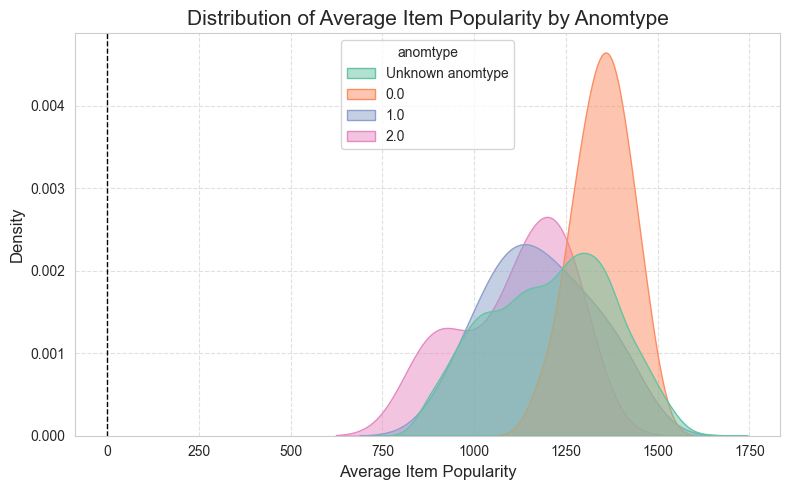

In [134]:
# Distribution of average item popularity by anomtype

plt.figure(figsize=(8, 5))
sns.kdeplot(
    data=df_tmp,
    x="avg_item_popularity",
    hue="anomtype",
    fill=True,
    common_norm=False,
    palette="Set2",
    alpha=0.5
)
plt.title("Distribution of Average Item Popularity by Anomtype", fontsize=15)
plt.xlabel("Average Item Popularity", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [135]:
# Calculate rare item ratio
item_popularity = X_no_dupes.groupby("item")["user"].nunique().rename("item_popularity")
item_rating_count = X_no_dupes.groupby("item").size().rename("item_rating_count")
df_tmp = X_no_dupes.merge(item_popularity, on="item", how="left")
df_tmp = df_tmp.merge(item_rating_count, on="item", how="left")

user_rare_item_ratio = df_tmp.groupby("user").apply(
    lambda x: (x["item_popularity"] < x["item_popularity"].quantile(0.25)).mean()
).rename("rare_item_ratio")

df_tmp = df_user_features.merge(user_rare_item_ratio, on="user", how="left")

# Merge with known and unknown anomtypes
df_tmp = pd.merge(df_tmp, y_cat_combined, on='user', how='left')
df_tmp["anomtype"] = df_tmp["anomtype"].apply(
    lambda x: x if pd.notnull(x) else "Unknown anomtype"
)

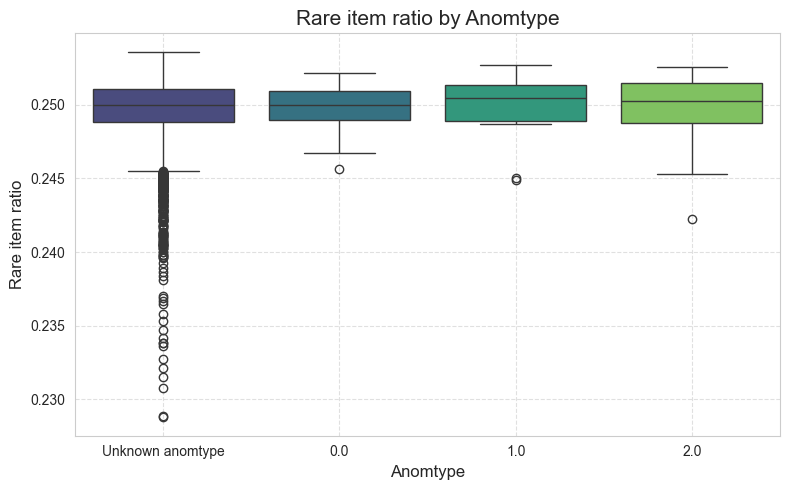

In [136]:
# Rare item ratio by Anomtype

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_tmp,
    x="anomtype",
    y="rare_item_ratio",
    palette="viridis"
)
plt.title("Rare item ratio by Anomtype", fontsize=15)
plt.xlabel("Anomtype", fontsize=12)
plt.ylabel("Rare item ratio", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

These features turned out to not be that discriminative, so we do not use them in the final feature set.

### Concentration features (Herfindahl index) [NOT USED IN FINAL]
Rating concentration measures how concentrated a user’s ratings are around specific values, using the Herfindahl index — the sum of squared rating proportions. A higher concentration means the user repeatedly gives the same rating (e.g., always 4 or 5), while a lower concentration indicates more balanced use of the rating scale. This feature helps identify users with overly uniform or polarized rating patterns, which can signal biased, automated, or otherwise anomalous behavior.

In [137]:
# Calculate Herfindahl index
rating_concentration = X_no_dupes.groupby("user")["rating"].apply(
    lambda x: (x.value_counts(normalize=True) ** 2).sum()
).rename("rating_concentration")
    
df_tmp = df_user_features.merge(rating_concentration, on="user", how="left")

# Merge with known and unknown anomtypes
df_tmp = pd.merge(df_tmp, y_cat_combined, on='user', how='left')
df_tmp["anomtype"] = df_tmp["anomtype"].apply(
    lambda x: x if pd.notnull(x) else "Unknown anomtype"
)

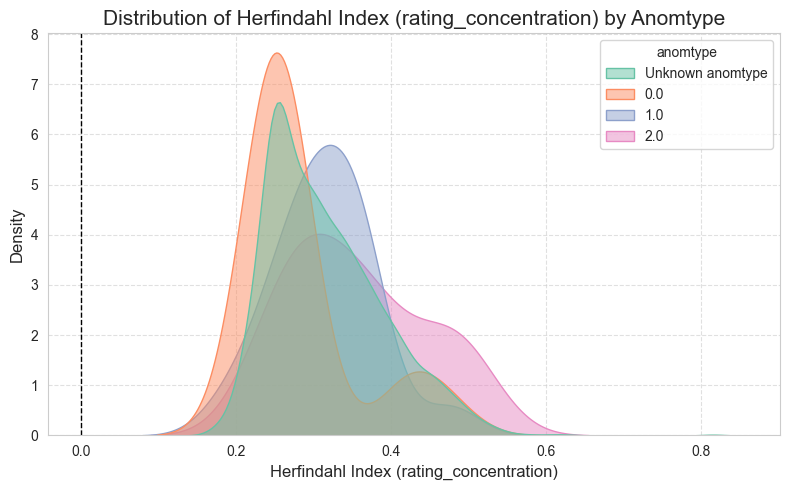

In [138]:
plt.figure(figsize=(8, 5))
sns.kdeplot(
    data=df_tmp,
    x="rating_concentration",
    hue="anomtype",
    fill=True,
    common_norm=False,
    palette="Set2",
    alpha=0.5
)
plt.title("Distribution of Herfindahl Index (rating_concentration) by Anomtype", fontsize=15)
plt.xlabel("Herfindahl Index (rating_concentration)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

This feature did not turn out to be as discriminative as expected, so we leave it out of the feature set.

### Review current df_user_features

In [139]:
df_user_features.head()

,mean_rating,median_rating,std_rating,min_rating,max_rating,count_dislike,count_neutral,count_like,total_interactions,user_mean_rank,...,neutral_ratio,interaction_ratio,weighted_score,rating_kurtosis,rating_skewness,user_bias,mean_item_alignment,outlier_frac,rating_entropy,extreme_ratio
user,,,,,,,,,,,,,,,,,,,,,
0,2.435644,2.0,1.145320,1,5,108,45,49,202,0.023611,...,0.222772,0.202,-88.5,-1.329120,0.128503,-0.746744,-0.673337,0.277228,1.407269,0.282178
1,2.698507,3.0,0.838000,1,5,138,154,43,335,0.131667,...,0.459701,0.335,-142.5,0.483190,0.429664,-0.423027,-0.389078,0.035821,1.212858,0.083582
2,3.904580,4.0,0.576070,2,5,1,54,207,262,0.804722,...,0.206107,0.262,309.0,0.281598,-0.120041,0.669767,0.611370,0.041985,0.866574,0.118321
3,3.801370,4.0,1.084853,0,5,35,50,207,292,0.752222,...,0.171233,0.292,258.0,1.122078,-1.088240,0.567449,0.530238,0.212329,1.373107,0.301370
4,4.373737,4.0,0.713693,2,5,7,6,185,198,0.971667,...,0.030303,0.198,267.0,2.109801,-1.271711,0.524326,0.498702,0.000000,0.935086,0.474747


### Final feature engineering function
We created our final feature engineering function, that will be used in the `PROJECT_week12.ipynb` document.

In [140]:
# Define the engineer_features function to add additional features

def engineer_features(df_X, df_y=None):
    df_X_no_dupes = df_X.drop_duplicates(subset=["user", "item"], keep="last")
    df_ratings = df_X_no_dupes.pivot(index='user', columns='item', values='rating').fillna(-1)
    all_items = range(0, 1000)
    df_ratings = df_ratings.reindex(columns=all_items, fill_value=-1)

    # Basic user features
    df_user_features = df_X.groupby("user").agg(
        mean_rating=("rating", "mean"),
        median_rating=("rating", "median"),
        std_rating=("rating", "std"),
        min_rating=("rating", "min"), # NEW
        max_rating=("rating", "max"), # NEW
        count_dislike=("rating", lambda x: ((x == 0) | (x == 1) | (x == 2)).sum()),
        count_neutral=("rating", lambda x: (x == 3).sum()),
        count_like=("rating", lambda x: ((x == 4) | (x == 5)).sum()),
        total_interactions=("rating", "count"),
    )

    df_user_features["rating_var"] = df_user_features["std_rating"] ** 2 # NEW
    df_user_features["normalized_std"] = ( # NEW
        df_user_features["std_rating"] / (df_user_features["mean_rating"] + 1e-5) # in case the mean_rating is 0
    )

    # Ratio features
    df_user_features["like_ratio"] = (
        df_user_features["count_like"] / df_user_features["total_interactions"]
    )
    df_user_features["dislike_ratio"] = (
        df_user_features["count_dislike"] / df_user_features["total_interactions"]
    )
    df_user_features["neutral_ratio"] = (
        df_user_features["count_neutral"] / df_user_features["total_interactions"]
    )
    num_items = df_X["item"].nunique()
    df_user_features["interaction_ratio"] = df_user_features["total_interactions"] / num_items

    # Weighted scores
    df_user_features["weighted_score"] = (
        df_user_features["count_like"] * 1.5 - df_user_features["count_dislike"] * 1.5
    )

    # Distribution features
    df_user_features["rating_kurtosis"] = df_X.groupby("user")["rating"].apply(
        lambda x: kurtosis(x)
    )
    df_user_features["rating_skewness"] = df_X.groupby("user")["rating"].apply(
        lambda x: skew(x)
    )

    # User bias
    item_means = df_X.groupby("item")["rating"].mean().rename("item_mean")
    df_tmp = df_X.merge(item_means, on="item", how="left")
    user_bias = df_tmp.groupby("user").apply(lambda df: (df["rating"] - df["item_mean"]).mean()).rename("user_bias")
    df_user_features.merge(user_bias, on="user", how="left")

    # Outliers
    item_stats = df_X.groupby("item")["rating"].agg(["mean", "std"]).rename(columns={"mean": "item_mean", "std": "item_std"})
    df_tmp = df_X.merge(item_stats, on="item", how="left")
    df_tmp["abs_dev"] = abs(df_tmp["rating"] - df_tmp["item_mean"])
    outlier_frac = (df_tmp["abs_dev"] > 1.5 * df_tmp["item_std"]).groupby(df_tmp["user"]).mean().rename("outlier_frac")
    df_user_features = df_user_features.merge(outlier_frac, on="user", how="left")

    # Mean item alignment
    df_tmp["z_score_item"] = (df_tmp["rating"] - df_tmp["item_mean"]) / (df_tmp["item_std"] + 1e-6)
    mean_item_alignment = df_tmp.groupby("user")["z_score_item"].mean().rename("mean_item_alignment")
    df_user_features = df_user_features.merge(mean_item_alignment, on="user", how="left")

    # Entropy and extreme behaviour
    user_entropy = df_X.groupby("user")["rating"].apply(
        lambda x: entropy(x.value_counts(normalize=True))
    ).rename("rating_entropy")
    extreme_ratio = df_X.groupby("user").apply(
        lambda df: ((df["rating"] == 1) | (df["rating"] == 5)).mean()
    ).rename("extreme_ratio")
    df_user_features = df_user_features.merge(user_entropy, on="user", how="left")
    df_user_features = df_user_features.merge(extreme_ratio, on="user", how="left")

    # User mean rank
    df_user_features["user_mean_rank"] = df_user_features["mean_rating"].rank(pct=True)

    # Fill NaN values
    df_user_features = df_user_features.fillna(0)

    final_df = pd.merge(df_ratings.reset_index(), df_user_features, on='user')
    
    if df_y is not None:
        df_merged = pd.merge(final_df.reset_index(), df_y, on="user", how="inner")
        return df_merged.drop(columns=["index"]).set_index("user")
    else:
        return final_df.set_index("user")

In [141]:
# Sanity check to confirm our engineer_features function works
final_df = engineer_features(X_combined, y_combined)
display(final_df)

,0,1,2,3,4,5,6,7,8,9,...,interaction_ratio,weighted_score,rating_kurtosis,rating_skewness,outlier_frac,mean_item_alignment,rating_entropy,extreme_ratio,user_mean_rank,label
user,,,,,,,,,,,,,,,,,,,,,
0,4.0,-1.0,-1.0,-1.0,4.0,-1.0,-1.0,-1.0,-1.0,4.0,...,0.202,-88.5,-1.329120,0.128503,0.272277,-0.676871,1.407269,0.282178,0.023889,0.962817
1,-1.0,-1.0,2.0,3.0,-1.0,2.0,-1.0,-1.0,3.0,-1.0,...,0.335,-142.5,0.483190,0.429664,0.038806,-0.400218,1.212858,0.083582,0.132500,0.031248
2,4.0,-1.0,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.262,309.0,0.281598,-0.120041,0.041985,0.606235,0.866574,0.118321,0.777639,0.068668
3,4.0,2.0,4.0,-1.0,1.0,3.0,-1.0,3.0,5.0,4.0,...,0.302,265.5,1.077512,-1.067422,0.211921,0.511695,1.374852,0.301325,0.732639,0.349012
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,-1.0,-1.0,...,0.342,483.0,2.194315,-1.079957,0.000000,0.437630,0.854248,0.467836,0.970278,0.917704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,3.0,3.0,-1.0,-1.0,3.0,-1.0,-1.0,-1.0,4.0,-1.0,...,0.254,127.5,0.528611,-0.784039,0.090551,-0.021406,1.299993,0.106299,0.480833,0.720721
3596,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.287,327.0,3.750245,-1.755136,0.045296,0.310142,1.217135,0.397213,0.847778,0.705247
3597,-1.0,-1.0,4.0,5.0,5.0,-1.0,-1.0,4.0,-1.0,4.0,...,0.313,327.0,3.153004,-1.635831,0.134185,0.521931,1.293681,0.354633,0.800000,0.362698
